In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from algorithms.moo.nsga2 import NSGA2
from constraints.as_obj import ConstraintsAsObjective
from operators.survival.rank_and_crowding.classes import (
    RankAndCrowding,
    MyConstrRankAndCrowding,
    ParallelConstrRankAndCrowding,
)
from optimize import minimize
from visualization.scatter import Scatter
from pymoo.problems import get_problem

In [4]:
core_moea1 = NSGA2(pop_size=500, survival=RankAndCrowding())
core_moea2 = NSGA2(pop_size=500, survival=MyConstrRankAndCrowding())
core_moea3 = NSGA2(pop_size=500, survival=ParallelConstrRankAndCrowding())

In [5]:
import time


def performance_timer(func):
    """
    A decorator to measure and print the execution time of a function.
    """

    def wrapper(*args, **kwargs):
        start_time = time.time()  # Capture the start time
        result = func(*args, **kwargs)  # Execute the function
        end_time = time.time()  # Capture the end time
        duration = end_time - start_time  # Calculate duration
        print(f"{func.__name__} executed in {duration:.6f} seconds")
        return result

    return wrapper


@performance_timer
def minimize_(*args, **kwargs):
    return minimize(*args, **kwargs)

In [6]:
from pymoo.indicators.gd import GD
from pymoo.indicators.gd_plus import GDPlus
from pymoo.indicators.igd import IGD
from pymoo.indicators.igd_plus import IGDPlus
from pymoo.indicators.hv import HV

metric_classes = {
    "Generational Distance (GD)": GD,
    "Generational Distance Plus (GD+)": GDPlus,
    "Inverted Generational Distance (IGD)": IGD,
    "Inverted Generational Distance Plus (IGD+)": IGDPlus,
    # "Hypervolume": HV,
}


def performance_indicators(pf, results):
    # Pre-configuration for each metric, handle special cases like HV here.
    pf_calculators = [
        (
            metric_class(ref_point=np.array([0, 0]))
            if metric_name == "Hypervolume"
            else metric_class(pf)
        )
        for metric_name, metric_class in metric_classes.items()
    ]

    def cal_acc_metric(sols):
        results_matrix = np.empty((len(sols), len(metric_classes)), dtype=object)

        for idx, sol in enumerate(sols):
            # Ensure `sol` is a 2D array with the correct shape [n_samples, n_features]
            sol = np.atleast_2d(sol)
            if sol.shape[0] == 1 and sol.shape[1] != len(pf):
                # This implies sol is a single sample with multiple features, which is the correct format
                pass
            elif sol.shape[1] == 1 and sol.shape[0] != len(pf):
                # This implies sol has the wrong orientation; it's many samples of a single feature
                sol = sol.T

            for metric_idx, calculator in enumerate(pf_calculators):
                try:
                    results_matrix[idx, metric_idx] = calculator(sol)
                except Exception as e:
                    # print(
                    #     f"Error calculating {list(metric_classes.keys())[metric_idx]}: {e}")
                    results_matrix[idx, metric_idx] = np.nan

        return [
            (np.mean(results_matrix[:, i]), np.median(results_matrix[:, i]))
            for i in range(len(pf_calculators))
        ]

    return [cal_acc_metric(rs) for rs in results]

In [17]:
from constraints.as_obj import CVRAsObjective, CDFAsObjective


@performance_timer
def compare_on(problem, n_gen=300):
    # Configuration for each optimization strategy
    configurations = [
        (problem, core_moea1, ("n_gen", n_gen), {"seed": 1, "verbose": False}),
        (ConstraintsAsObjective(problem),
         core_moea1, ("n_gen", n_gen), {"seed": 1}),
        (ConstraintsAsObjective(problem),
         core_moea2, ("n_gen", n_gen), {"seed": 1}),
        (
            CVRAsObjective(problem),
            core_moea2,
            ("n_gen", n_gen),
            {"seed": 1, "verbose": False},
        ),
        (
            CDFAsObjective(problem),
            core_moea2,
            ("n_gen", n_gen),
            {"seed": 1, "verbose": False},
        ),
    ]

    results = []
    for config in configurations:
        result = minimize_(*config[:-1], **config[-1])
        results.append(result)
    return results


def test(problem_name, n_gen=300, *args):
    if "dascmop" in problem_name:
        problem = get_problem(problem_name, args[0])
    if "modact" in problem_name:
        problem = get_problem(problem_name, args[0])
    else:
        problem = get_problem(problem_name)
    pf = problem.pareto_front()
    print(
        f"Problem {problem.name}: n_var={problem.n_var} n_obj={problem.n_obj} n_ieq_constr={problem.n_ieq_constr} n_eq_constr={problem.n_eq_constr}"
    )

    results = compare_on(problem, n_gen=n_gen)

    # Check if any of the results is None
    if any(result is None for result in results):
        print("One or more optimization runs failed to return a result.")
        # Return None in place of results to indicate failure
        return pf, [None] * len(results)

    # Prepare data for performance indicators, safely handling cases where result.F might be None or incorrectly shaped
    prepared_data = []
    for i, result in enumerate(results):
        if result and hasattr(result, "F") and result.F is not None:
            # i == 0 this NGSA without additional objective
            if i > 0:
                prepared_data.append(result.F[:, :-1])
            else:
                prepared_data.append(result.F)
        else:
            # Use None or an appropriate placeholder if result is invalid
            prepared_data.append(None)

    # Ensure all data is valid before calculating performance indicators
    if all(data is not None for data in prepared_data):
        performance_results = performance_indicators(pf, prepared_data)
        for i, metric in enumerate(metric_classes.keys()):
            print(
                f"{metric}: " +
                " | ".join(f"{perf[i]}" for perf in performance_results)
            )
    else:
        print("Performance indicators could not be calculated due to invalid data.")

    return pf, *results

# BNH


In [8]:
pf, *results = test("bnh", n_gen=300)

Problem <bound method Problem.name of <pymoo.problems.multi.bnh.BNH object at 0x11c020f10>>: n_var=2 n_obj=2 n_ieq_constr=2 n_eq_constr=0


KeyboardInterrupt: 

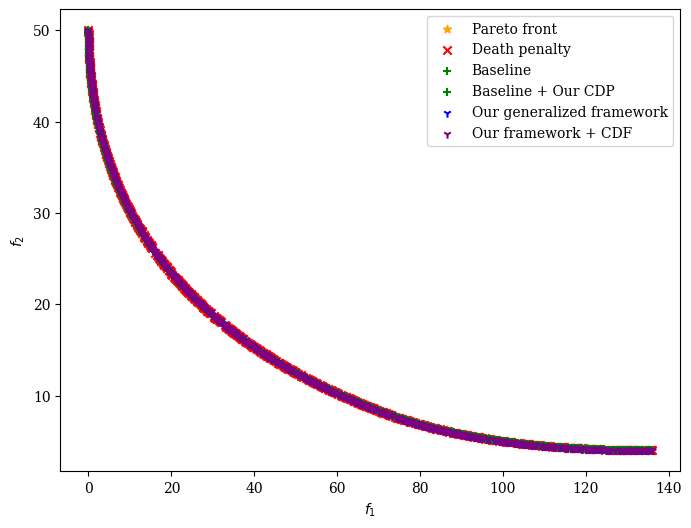

In [ ]:
plot = Scatter()
plot.add(pf, marker="*", color="orange", label="Pareto front")
plot.add(results[0].F, marker="x", color="red", label="Death penalty")
plot.add(results[1].F[:, :-1], marker="+", color="green", label="Baseline")
plot.add(results[2].F[:, :-1], marker="+",
         color="green", label="Baseline + Our CDP")
plot.add(
    results[3].F[:, :-1], marker="1", color="blue", label="Our generalized framework"
)
plot.add(results[4].F[:, :-1], marker="1",
         color="purple", label="Our framework + CDF")
plot.show()

# ZDT


In [ ]:
# problem_zdt1 = get_problem("zdt1")
# problem = problem_zdt1
# print(
#     f"Problem {problem.name}: n_var={problem.n_var} n_obj={problem.n_obj} n_ieq_constr={problem.n_ieq_constr} n_eq_constr={problem.n_eq_constr}"
# )

# res0, res1, res2, res3 = compare_on(problem)
# print(
#     f"F1-F2: {sum(res1.F - res2.F)}   F2-F3{sum(res2.F - res3.F)}   F1-F3{sum(res1.F - res3.F)}"
# )

# plot = Scatter()
# plot.add(problem.pareto_front(), marker="*", color="orange", label="Pareto front")
# plot.add(res0.F, marker="x", color="red", label="Death penalty")
# plot.add(res1.F[:, :-1], marker="+", color="green", label="Baseline CV_as_obj")
# plot.add(res2.F[:, :-1], marker="1", color="blue", label="Our CV_as_obj")
# plot.add(res3.F[:, :-1], marker="1", color="purple", label="Our CV_as_obj")
# plot.show()

In [ ]:
# problem_zdt2 = get_problem("zdt2")

# res0, res1, res2, res3 = compare_on(problem_zdt2)

# plot = Scatter()
# plot.add(problem_zdt2.pareto_front(), marker="*", color="orange", label="Pareto front")
# plot.add(res0.F, marker="x", color="red", label="Death penalty")
# plot.add(res1.F[:, :-1], marker="+", color="green", label="Baseline CV_as_obj")
# plot.add(res2.F[:, :-1], marker="1", color="blue", label="Our CV_as_obj")
# plot.add(res3.F[:, :-1], marker="1", color="purple", label="Our CV_as_obj")
# plot.show()

In [ ]:
# problem_zdt3 = get_problem("zdt3")

# res0, res1, res2, res3 = compare_on(problem_zdt3)

# plot = Scatter()
# plot.add(problem_zdt3.pareto_front(), marker="*", color="orange", label="Pareto front")
# plot.add(res0.Fa, marker="x", color="red", label="Death penalty")
# plot.add(res1.F[:, :-1], marker="+", color="green", label="Baseline CV_as_obj")
# plot.add(res2.F[:, :-1], marker="1", color="blue", label="Our CV_as_obj")
# plot.add(res3.F[:, :-1], marker="1", color="purple", label="Our CV_as_obj")
# plot.show()

In [ ]:
# problem_zdt4 = get_problem("zdt4")

# res0, res1, res2, res3 = compare_on(problem_zdt4)
# print(
#     f"F1-F2: {sum(res1.F - res2.F)}   F2-F3{sum(res2.F - res3.F)}   F1-F3{sum(res1.F - res3.F)}"
# )

# plot = Scatter()
# plot.add(problem_zdt4.pareto_front(), marker="*", color="orange", label="Pareto front")
# plot.add(res0.F, marker="x", color="red", label="Death penalty")
# plot.add(res1.F[:, :-1], marker="+", color="green", label="Baseline CV_as_obj")
# plot.add(res2.F[:, :-1], marker="1", color="blue", label="Our CV_as_obj")
# plot.add(res3.F[:, :-1], marker="1", color="purple", label="Our CV_as_obj")
# plot.show()

In [ ]:
# problem_zdt5 = get_problem("zdt5", normalize=False)

# res0, res1, res2, res3 = compare_on(problem_zdt5, n_gen=3000)
# print(
#     f"F1-F2: {sum(res1.F - res2.F)}   F2-F3{sum(res2.F - res3.F)}   F1-F3{sum(res1.F - res3.F)}"
# )

# plot = Scatter()
# plot.add(problem_zdt5.pareto_front(), marker="*", color="orange", label="Pareto front")
# plot.add(res0.F, marker="x", color="red", label="Death penalty")
# plot.add(res1.F[:, :-1], marker="+", color="green", label="Baseline CV_as_obj")
# plot.add(res2.F[:, :-1], marker="1", color="blue", label="Our CV_as_obj")
# plot.add(res3.F[:, :-1], marker="1", color="purple", label="Our CV_as_obj")
# plot.show()

In [ ]:
# problem_zdt6 = get_problem("zdt6")

# res0, res1, res2, res3 = compare_on(problem_zdt6)
# print(
#     f"F1-F2: {sum(res1.F - res2.F)}   F2-F3{sum(res2.F - res3.F)}   F1-F3{sum(res1.F - res3.F)}"
# )

# plot = Scatter()
# plot.add(problem_zdt6.pareto_front(), marker="*", color="orange", label="Pareto front")
# plot.add(res0.F, marker="x", color="red", label="Death penalty")
# plot.add(res1.F[:, :-1], marker="+", color="green", label="Baseline CV_as_obj")
# plot.add(res2.F[:, :-1], marker="1", color="blue", label="Our CV_as_obj")
# plot.add(res3.F[:, :-1], marker="1", color="purple", label="Our CV_as_obj")
# plot.show()

In [ ]:
# cv = res3.F[:, 0]
# least_infeas = cv.argmin()
# x = res3.X[least_infeas]

# sol = Individual(X=x)
# Evaluator().eval(problem2, sol)

# print("Best solution found: \nX = %s\nF = %s\nCV = %s" % (sol.X, sol.F, sol.CV))

In [ ]:
# plot = Scatter()
# plot.add(problem2.pareto_front(), marker="*", color="black", alpha=0.7, s=100)
# plot.add(res3.F[:,1:], facecolor="none", edgecolor="red")
# plot.show()

In [ ]:
# X, F = res3.opt.get("X", "F")
# hist = res3.history
# print(len(hist))

In [ ]:
# n_evals = []             # corresponding number of function evaluations\
# hist_F = []              # the objective space values in each generation
# hist_cv = []             # constraint violation in each generation
# hist_cv_avg = []         # average constraint violation in the whole population

# for algo in hist:

#     # store the number of function evaluations
#     n_evals.append(algo.evaluator.n_eval)

#     # retrieve the optimum from the algorithm
#     opt = algo.opt

#     # store the least contraint violation and the average in each population
#     hist_cv.append(opt.get("CV").min())
#     hist_cv_avg.append(algo.pop.get("CV").mean())

#     # filter out only the feasible and append and objective space values
#     feas = np.where(opt.get("feasible"))[0]
#     hist_F.append(opt.get("F")[feas])

In [ ]:
# k = np.where(np.array(hist_cv) <= 0.0)[0].min()
# print(f"At least one feasible solution in Generation {k} after {n_evals[k]} evaluations.")

In [ ]:
# # replace this line by `hist_cv` if you like to analyze the least feasible optimal solution and not the population
# vals = hist_cv_avg

# k = np.where(np.array(vals) <= 0.0)[0].min()
# print(f"Whole population feasible in Generation {k} after {n_evals[k]} evaluations.")

# plt.figure(figsize=(7, 5))
# plt.plot(n_evals, vals,  color='black', lw=0.7, label="Avg. CV of Pop")
# plt.scatter(n_evals, vals,  facecolor="none", edgecolor='black', marker="p")
# plt.axvline(n_evals[k], color="red", label="All Feasible", linestyle="--")
# plt.title("Convergence")
# plt.xlabel("Function Evaluations")
# plt.ylabel("Hypervolume")
# plt.legend()
# plt.show()

In [ ]:
# approx_ideal = F[:,-2:].min(axis=0)
# approx_nadir = F[:,-2:].max(axis=0)
# approx_ideal, approx_nadir

In [ ]:
# from pymoo.indicators.hv import Hypervolume

# metric = Hypervolume(ref_point=np.array([0.1, 0.1]),
#                      norm_ref_point=False,
#                      zero_to_one=True,
#                      ideal=approx_ideal,
#                      nadir=approx_nadir)

# hv = [metric.do(_F[:, -2:]) for _F in hist_F]

# plt.figure(figsize=(7, 5))
# plt.plot(n_evals, hv, color='black', lw=0.7, label="Avg. CV of Pop")
# plt.scatter(n_evals, hv, facecolor="none", edgecolor='black', marker="p")
# plt.title("Convergence")
# plt.xlabel("Function Evaluations")
# plt.ylabel("Hypervolume")
# plt.show()

In [ ]:
# from pymoo.util.running_metric import RunningMetricAnimation

# running = RunningMetricAnimation(delta_gen=5,
#                         n_plots=3,
#                         key_press=False,
#                         do_show=True)

# for algorithm in res3.history[:50]:
#     running.update(algorithm)

In [ ]:
# from pymoo.indicators.igd import IGD

# metric = IGD(pf, zero_to_one=True)

# igd = [metric.do(_F) for _F in hist_F]

# plt.plot(n_evals, igd,  color='black', lw=0.7, label="Avg. CV of Pop")
# plt.scatter(n_evals, igd,  facecolor="none", edgecolor='black', marker="p")
# plt.axhline(10**-2, color="red", label="10^-2", linestyle="--")
# plt.title("Convergence")
# plt.xlabel("Function Evaluations")
# plt.ylabel("IGD")
# plt.yscale("log")
# plt.legend()
# plt.show()

# OSY


In [ ]:
pf, *results = test("osy", n_gen=300)

Problem <bound method Problem.name of <pymoo.problems.multi.osy.OSY object at 0x77deb4201b70>>: n_var=6 n_obj=2 n_ieq_constr=6 n_eq_constr=0
minimize_ executed in 13.756021 seconds
minimize_ executed in 11.864218 seconds
minimize_ executed in 11.386663 seconds
minimize_ executed in 11.207125 seconds
minimize_ executed in 11.107908 seconds
compare_on executed in 59.322718 seconds
Generational Distance (GD): (1.548172363860012, 0.4475210725206491) | (829.562726224257, 915.2654113493448) | (1.2753342524527065, 0.41104577141073184) | (1.3152017586179299, 0.44134523548948035) | (1.1933719214047112, 0.41710013064345763)
Generational Distance Plus (GD+): (0.7253559385751795, 0.18440516602552032) | (49.24616894343895, 18.57042617894414) | (0.4773663216216407, 0.1859457024076061) | (0.4919517014773616, 0.17971217022686403) | (0.42842816315941273, 0.1905996506049803)
Inverted Generational Distance (IGD): (76.2036579878438, 63.99254205435368) | (891.6848174023221, 973.9438817572113) | (74.5091514

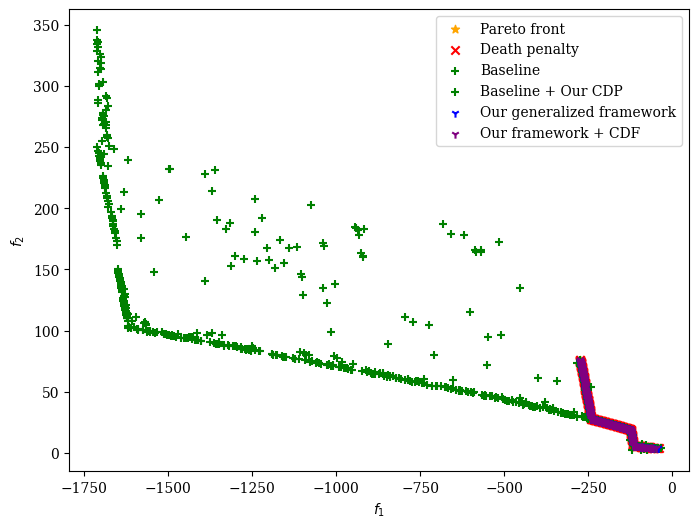

In [ ]:
plot = Scatter()
plot.add(pf, marker="*", color="orange", label="Pareto front")
plot.add(results[0].F, marker="x", color="red", label="Death penalty")
plot.add(results[1].F[:, :-1], marker="+", color="green", label="Baseline")
plot.add(results[2].F[:, :-1], marker="+",
         color="green", label="Baseline + Our CDP")
plot.add(
    results[3].F[:, :-1], marker="1", color="blue", label="Our generalized framework"
)
plot.add(results[4].F[:, :-1], marker="1",
         color="purple", label="Our framework + CDF")
plot.show()

# TNK


In [ ]:
pf, *results = test("tnk", n_gen=300)

Problem <bound method Problem.name of <pymoo.problems.multi.tnk.TNK object at 0x77deb6b81de0>>: n_var=2 n_obj=2 n_ieq_constr=2 n_eq_constr=0
minimize_ executed in 12.780121 seconds
minimize_ executed in 12.451465 seconds
minimize_ executed in 11.439942 seconds
minimize_ executed in 10.844156 seconds
minimize_ executed in 10.516022 seconds
compare_on executed in 58.032431 seconds
Generational Distance (GD): (0.003883997810563278, 0.0025571630316454713) | (0.2849026209030071, 0.23123031766051982) | (0.0038136139519507808, 0.0023928611070053963) | (0.0034794821696909175, 0.002518006042838851) | (0.00386604387933029, 0.0024108111550060632)
Generational Distance Plus (GD+): (0.0017474713104235413, 0.0016730477884204786) | (0.001133719634940556, 0.0) | (0.001675616354900305, 0.0015625574816873766) | (0.0017180339449633984, 0.0016671715519005481) | (0.001753619549360049, 0.0016834045249232849)
Inverted Generational Distance (IGD): (0.5120667101684252, 0.4536588042693558) | (0.6334792263298323

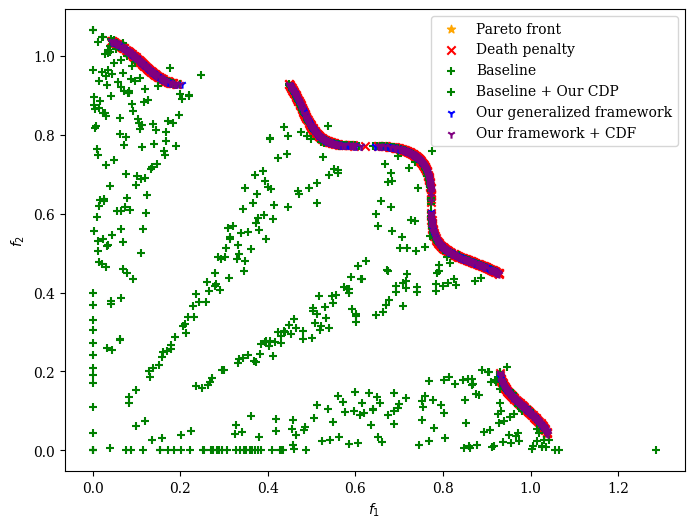

In [ ]:
plot = Scatter()
plot.add(pf, marker="*", color="orange", label="Pareto front")
plot.add(results[0].F, marker="x", color="red", label="Death penalty")
plot.add(results[1].F[:, :-1], marker="+", color="green", label="Baseline")
plot.add(results[2].F[:, :-1], marker="+",
         color="green", label="Baseline + Our CDP")
plot.add(
    results[3].F[:, :-1], marker="1", color="blue", label="Our generalized framework"
)
plot.add(results[4].F[:, :-1], marker="1",
         color="purple", label="Our framework + CDF")
plot.show()

In [ ]:
# plt.hist(res1.F[:, -1:], bins=30, color="green", alpha=0.7, label="Sum CV_as_obj")
# plt.hist(res2.F[:, -1:], bins=30, color="blue", alpha=0.7, label="Max CV_as_obj")
# plt.hist(res3.F[:, -1:], bins=30, color="purple", alpha=0.7, label="Median CV_as_obj")

# Add labels and title
# plt.xlabel("Values")
# plt.ylabel("Frequency")
# plt.title("Histogram of CV")

# Add a legend
# plt.legend()

# Show the plot
# plt.show()

# Carside


In [ ]:
pf, *results = test("Carside", n_gen=300)

Problem <bound method Problem.name of <pymoo.problems.multi.carside.Carside object at 0x77deb3b926e0>>: n_var=7 n_obj=3 n_ieq_constr=10 n_eq_constr=0
minimize_ executed in 14.088331 seconds
minimize_ executed in 12.789946 seconds
minimize_ executed in 12.928652 seconds
minimize_ executed in 12.226192 seconds
minimize_ executed in 11.851757 seconds
compare_on executed in 63.885449 seconds
Generational Distance (GD): (1.0751799757995857, 0.44428028713003404) | (4.025401403179686, 3.7034250590596125) | (1.0193735548157594, 0.4217859035450713) | (1.0634622185034817, 0.4527165662024826) | (1.0475739542451554, 0.4451764523003983)
Generational Distance Plus (GD+): (0.6060496507840735, 0.0) | (0.5463864261039428, 0.2922912025668942) | (0.5657495516100587, 0.0) | (0.6105079015128634, 0.0) | (0.5943487724538228, 0.0)
Inverted Generational Distance (IGD): (5.051028864618003, 4.701727056082563) | (9.093950980153803, 9.379116614952796) | (4.932181919559349, 4.553769136162403) | (5.015399686013543, 

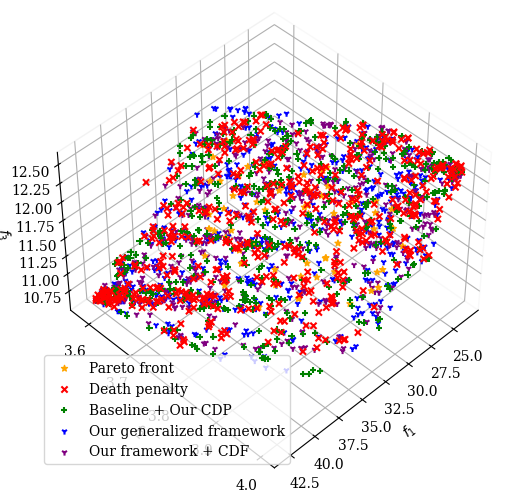

In [ ]:
plot = Scatter()
plot.add(pf, marker="*", color="orange", label="Pareto front")
plot.add(results[0].F, marker="x", color="red", label="Death penalty")
# plot.add(results[1].F[:, :-1], marker="+", color="green", label="Baseline")
plot.add(results[2].F[:, :-1], marker="+",
         color="green", label="Baseline + Our CDP")
plot.add(
    results[3].F[:, :-1], marker="1", color="blue", label="Our generalized framework"
)
plot.add(results[4].F[:, :-1], marker="1",
         color="purple", label="Our framework + CDF")
plot.show()

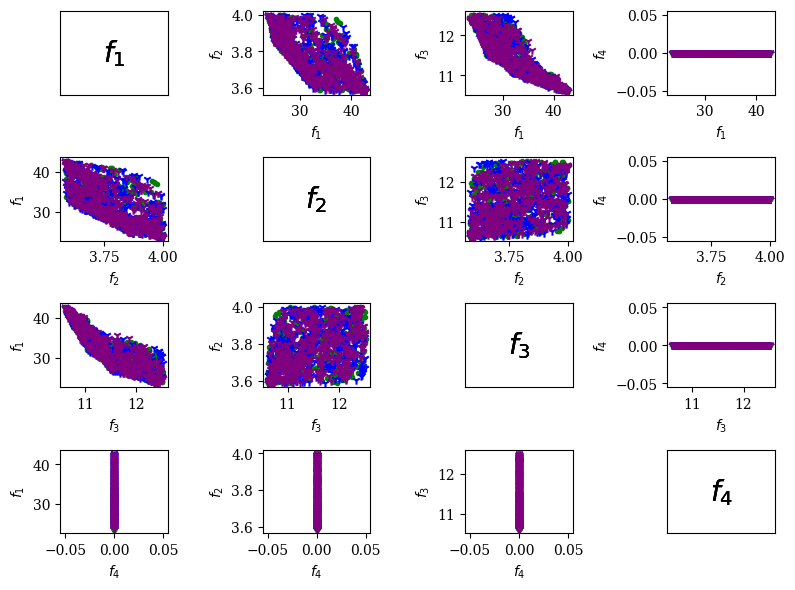

In [ ]:
plot = Scatter(tight_layout=True)
# plot.add(results[1].F, marker="+", color="green", label="Baseline")
plot.add(results[2].F, marker=".", color="green", label="Baseline + Our CDP")
plot.add(results[3].F, marker="1", color="blue",
         label="Our generalized framework")
plot.add(results[4].F, marker="1", color="purple", label="Our framework + CDF")
plot.show()

# Pressure Vessel


In [ ]:
pf, *results = test("pressure_vessel", n_gen=300)

Problem <bound method Problem.name of <pymoo.problems.single.pressure_vessel.PressureVessel object at 0x77deb368b790>>: n_var=4 n_obj=1 n_ieq_constr=4 n_eq_constr=0
minimize_ executed in 11.615453 seconds
minimize_ executed in 11.591374 seconds
minimize_ executed in 10.639376 seconds


KeyboardInterrupt: 

In [ ]:
plot = Scatter()
plot.add(pf, marker="*", color="orange", label="Pareto front")
plot.add(results[0].F, marker="x", color="red", label="Death penalty")
# plot.add(results[1].F[:, :-1], marker="+", color="green", label="Baseline")
plot.add(results[2].F[:, :-1], marker="+",
         color="green", label="Baseline + Our CDP")
plot.add(
    results[3].F[:, :-1], marker="1", color="blue", label="Our generalized framework"
)
plot.add(results[4].F[:, :-1], marker="1",
         color="purple", label="Our framework + CDF")
plot.show()

# G


## G1


In [ ]:
pf, *results = test("g1", n_gen=500)

Problem <bound method Problem.name of <pymoo.problems.single.g.G1 object at 0x77dea34935e0>>: n_var=13 n_obj=1 n_ieq_constr=9 n_eq_constr=0
minimize_ executed in 23.355531 seconds
minimize_ executed in 20.672504 seconds
minimize_ executed in 23.185326 seconds
minimize_ executed in 21.676105 seconds
minimize_ executed in 18.296636 seconds
compare_on executed in 107.186714 seconds
Generational Distance (GD): (0.0016790338567567176, 0.0016790338567567176) | (147.04371581080895, 148.90396737960208) | (0.001833595847195113, 0.001833595847195113) | (0.003001174240726101, 0.003001174240726101) | (0.0008281143828163806, 0.0008281143828163806)
Generational Distance Plus (GD+): (0.0016790338567567176, 0.0016790338567567176) | (0.0004113233858684282, 0.0) | (0.001833595847195113, 0.001833595847195113) | (0.003001174240726101, 0.003001174240726101) | (0.0008281143828163806, 0.0008281143828163806)
Inverted Generational Distance (IGD): (0.0016790338567567176, 0.0016790338567567176) | (147.0437158108

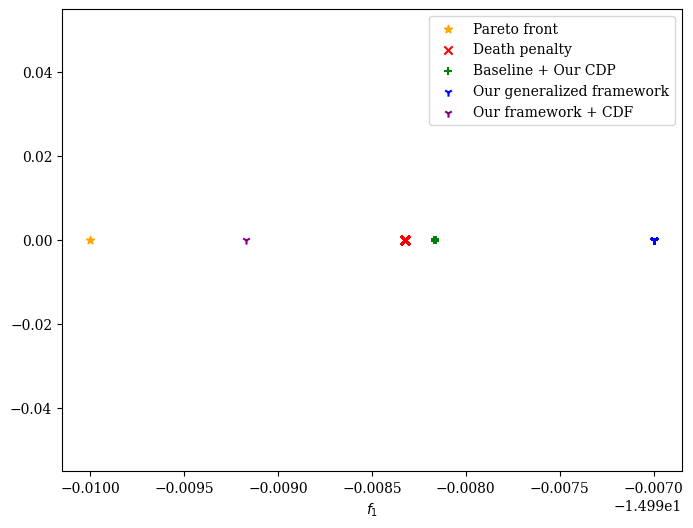

In [ ]:
plot = Scatter()
plot.add(pf, marker="*", color="orange", label="Pareto front")
plot.add(results[0].F, marker="x", color="red", label="Death penalty")
# plot.add(results[1].F[:, :-1], marker="+", color="green", label="Baseline")
plot.add(results[2].F[:, :-1], marker="+",
         color="green", label="Baseline + Our CDP")
plot.add(
    results[3].F[:, :-1], marker="1", color="blue", label="Our generalized framework"
)
plot.add(results[4].F[:, :-1], marker="1",
         color="purple", label="Our framework + CDF")
plot.show()

## G2


In [ ]:
pf, *results = test("g2", n_gen=500)

Problem <bound method Problem.name of <pymoo.problems.single.g.G2 object at 0x77deb6554640>>: n_var=20 n_obj=1 n_ieq_constr=2 n_eq_constr=0
minimize_ executed in 23.335690 seconds
minimize_ executed in 23.373137 seconds
minimize_ executed in 20.577813 seconds
minimize_ executed in 18.968115 seconds
minimize_ executed in 19.963906 seconds
compare_on executed in 106.219270 seconds
Generational Distance (GD): (0.0020737702320930973, 0.0020737702320930973) | (1.064842630149124, 0.0847612045360619) | (0.0020737702320930973, 0.0020737702320930973) | (0.0020737702320930973, 0.0020737702320930973) | (0.0020737702320930973, 0.0020737702320930973)
Generational Distance Plus (GD+): (0.0020737702320930973, 0.0020737702320930973) | (6.510290840264777e-07, 0.0) | (0.0020737702320930973, 0.0020737702320930973) | (0.0020737702320930973, 0.0020737702320930973) | (0.0020737702320930973, 0.0020737702320930973)
Inverted Generational Distance (IGD): (0.0020737702320930973, 0.0020737702320930973) | (1.06484

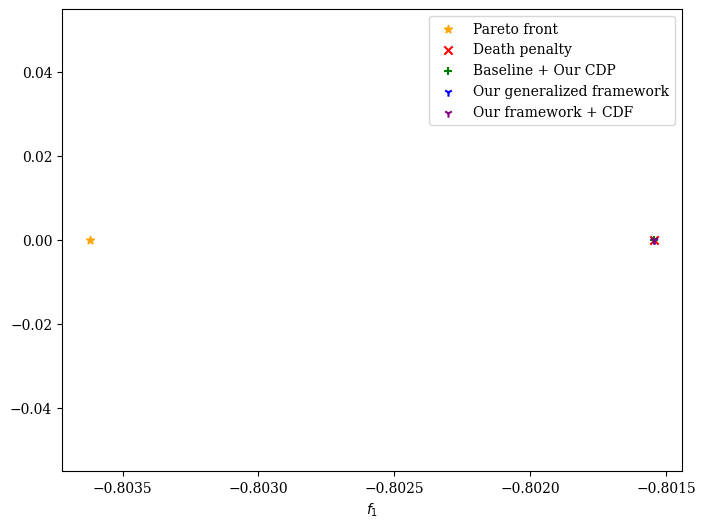

In [43]:
plot = Scatter()
plot.add(pf, marker="*", color="orange", label="Pareto front")
plot.add(results[0].F, marker="x", color="red", label="Death penalty")
# plot.add(results[1].F[:, :-1], marker="+", color="green", label="Baseline")
plot.add(results[2].F[:, :-1], marker="+",
         color="green", label="Baseline + Our CDP")
plot.add(
    results[3].F[:, :-1], marker="1", color="blue", label="Our generalized framework"
)
plot.add(results[4].F[:, :-1], marker="1",
         color="purple", label="Our framework + CDF")
plot.show()

## G3 (1 Constraint)


In [ ]:
# pf, res0, res1, res2, res3 = test("g3", n_gen=300)

In [ ]:
plot = Scatter()
plot.add(pf, marker="*", color="orange", label="Pareto front")
plot.add(res0.F, marker="x", color="red", label="Death penalty")
# plot.add(res1.F[:, :-1], marker="+", color="green", label="Baseline")
plot.add(res2.F[:, :-1], marker="1", color="blue", label="Our generalized framework")
plot.add(res3.F[:, :-1], marker="1", color="purple", label="Our framework + CDF")
plot.show()

## G4


In [ ]:
pf, res0, res1, res2, res3 = test("g4", n_gen=300)

In [ ]:
plot = Scatter()
plot.add(pf, marker="*", color="orange", label="Pareto front")
plot.add(res0.F, marker="x", color="red", label="Death penalty")
plot.add(res1.F[:, :-1], marker="+", color="green", label="Baseline")
plot.add(res2.F[:, :-1], marker="1", color="blue", label="Our generalized framework")
plot.add(res3.F[:, :-1], marker="1", color="purple", label="Our framework + CDF")
plot.show()

## G5


In [ ]:
pf, res0, res1, res2, res3 = test("g5", n_gen=300)

In [ ]:
pf

In [ ]:
res0.F

In [ ]:
res2.F

In [ ]:
res3.F

In [ ]:
plot = Scatter()
plot.add(pf, marker="*", color="orange", label="Pareto front")
plot.add(res0.F, marker="x", color="red", label="Death penalty")
# plot.add(res1.F[:, :-1], marker="+", color="green", label="Baseline")
plot.add(res2.F[:, :-1], marker="1", color="blue", label="Our generalized framework")
plot.add(res3.F[:, :-1], marker="1", color="purple", label="Our framework + CDF")
plot.show()

## G6


In [ ]:
pf, res0, res1, res2, res3 = test("g6", n_gen=300)

In [ ]:
plot = Scatter()
plot.add(pf, marker="*", color="orange", label="Pareto front")
plot.add(res0.F, marker="x", color="red", label="Death penalty")
# plot.add(res1.F[:, :-1], marker="+", color="green", label="Baseline")
plot.add(res2.F[:, :-1], marker="1", color="blue", label="Our generalized framework")
plot.add(res3.F[:, :-1], marker="1", color="purple", label="Our framework + CDF")
plot.show()

## G7


In [ ]:
pf, res0, res1, res2, res3 = test("g7", n_gen=300)

In [ ]:
plot = Scatter()
plot.add(pf, marker="*", color="orange", label="Pareto front")
plot.add(res0.F, marker="x", color="red", label="Death penalty")
# plot.add(res1.F[:, :-1], marker="+", color="green", label="Baseline")
plot.add(res2.F[:, :-1], marker="1", color="blue", label="Our generalized framework")
plot.add(res3.F[:, :-1], marker="1", color="purple", label="Our framework + CDF")
plot.show()

## G8


In [ ]:
pf, res0, res1, res2, res3 = test("g8", n_gen=300)

In [ ]:
plot = Scatter()
plot.add(pf, marker="*", color="orange", label="Pareto front")
plot.add(res0.F, marker="x", color="red", label="Death penalty")
# plot.add(res1.F[:, :-1], marker="+", color="green", label="Baseline")
plot.add(res2.F[:, :-1], marker="1", color="blue", label="Our generalized framework")
plot.add(res3.F[:, :-1], marker="1", color="purple", label="Our framework + CDF")
plot.show()

## G9


In [ ]:
pf, res0, res1, res2, res3 = test("g9", n_gen=300)

In [ ]:
plot = Scatter()
plot.add(pf, marker="*", color="orange", label="Pareto front")
plot.add(res0.F, marker="x", color="red", label="Death penalty")
# plot.add(res1.F[:, :-1], marker="+", color="green", label="Baseline")
plot.add(res2.F[:, :-1], marker="1", color="blue", label="Our generalized framework")
plot.add(res3.F[:, :-1], marker="1", color="purple", label="Our framework + CDF")
plot.show()

## G10


In [ ]:
pf, res0, res1, res2, res3 = test("g10", n_gen=300)

In [ ]:
plot = Scatter()
plot.add(pf, marker="*", color="orange", label="Pareto front")
plot.add(res0.F, marker="x", color="red", label="Death penalty")
# plot.add(res1.F[:, :-1], marker="+", color="green", label="Baseline")
plot.add(res2.F[:, :-1], marker="1", color="blue", label="Our generalized framework")
plot.add(res3.F[:, :-1], marker="1", color="purple", label="Our framework + CDF")
plot.show()

## G11


In [ ]:
pf, res0, res1, res2, res3 = test("g11", n_gen=300)

In [ ]:
plot = Scatter()
plot.add(pf, marker="*", color="orange", label="Pareto front")
plot.add(res0.F, marker="x", color="red", label="Death penalty")
# plot.add(res1.F[:, :-1], marker="+", color="green", label="Baseline")
plot.add(res2.F[:, :-1], marker="1", color="blue", label="Our generalized framework")
plot.add(res3.F[:, :-1], marker="1", color="purple", label="Our framework + CDF")
plot.show()

## G12


In [ ]:
pf, res0, res1, res2, res3 = test("g12", n_gen=300)

In [ ]:
plot = Scatter()
plot.add(pf, marker="*", color="orange", label="Pareto front")
plot.add(res0.F, marker="x", color="red", label="Death penalty")
# plot.add(res1.F[:, :-1], marker="+", color="green", label="Baseline")
plot.add(res2.F[:, :-1], marker="1", color="blue", label="Our generalized framework")
plot.add(res3.F[:, :-1], marker="1", color="purple", label="Our framework + CDF")
plot.show()

## G13


In [ ]:
pf, res0, res1, res2, res3 = test("g13", n_gen=300)

In [ ]:
plot = Scatter()
plot.add(pf, marker="*", color="orange", label="Pareto front")
plot.add(res0.F, marker="x", color="red", label="Death penalty")
# plot.add(res1.F[:, :-1], marker="+", color="green", label="Baseline")
plot.add(res2.F[:, :-1], marker="1", color="blue", label="Our generalized framework")
plot.add(res3.F[:, :-1], marker="1", color="purple", label="Our framework + CDF")
plot.show()

## G14


In [ ]:
pf, res0, res1, res2, res3 = test("g14", n_gen=300)

In [ ]:
plot = Scatter()
plot.add(pf, marker="*", color="orange", label="Pareto front")
plot.add(res0.F, marker="x", color="red", label="Death penalty")
# plot.add(res1.F[:, :-1], marker="+", color="green", label="Baseline")
plot.add(res2.F[:, :-1], marker="1", color="blue", label="Our generalized framework")
plot.add(res3.F[:, :-1], marker="1", color="purple", label="Our framework + CDF")
plot.show()

# MW


## MW1 (1 constraint)


In [ ]:
pf, *results = test("mw", n_gen=300)

In [ ]:
plot = Scatter()
plot.add(pf, marker="*", color="orange", label="Pareto front")
plot.add(results[0].F, marker="x", color="red", label="Death penalty")
# plot.add(results[1].F[:, :-1], marker="+", color="green", label="Baseline")
plot.add(results[2].F[:, :-1], marker="+",
         color="green", label="Baseline + Our CDP")
plot.add(
    results[3].F[:, :-1], marker="1", color="blue", label="Our generalized framework"
)
plot.add(results[4].F[:, :-1], marker="1",
         color="purple", label="Our framework + CDF")
plot.show()

## MW2


In [ ]:
pf, *results = test("mw2", n_gen=100)

In [ ]:
plot = Scatter()
plot.add(pf, marker="*", color="orange", label="Pareto front")
plot.add(results[0].F, marker="x", color="red", label="Death penalty")
# plot.add(results[1].F[:, :-1], marker="+", color="green", label="Baseline")
plot.add(results[2].F[:, :-1], marker="+",
         color="green", label="Baseline + Our CDP")
plot.add(
    results[3].F[:, :-1], marker="1", color="blue", label="Our generalized framework"
)
plot.add(results[4].F[:, :-1], marker="1",
         color="purple", label="Our framework + CDF")
plot.show()

## MW3


In [ ]:
pf, *results = test("mw3", n_gen=500)

In [ ]:
plot = Scatter()
plot.add(pf, marker="*", color="orange", label="Pareto front")
plot.add(results[0].F, marker="x", color="red", label="Death penalty")
# plot.add(results[1].F[:, :-1], marker="+", color="green", label="Baseline")
plot.add(results[2].F[:, :-1], marker="+",
         color="green", label="Baseline + Our CDP")
plot.add(
    results[3].F[:, :-1], marker="1", color="blue", label="Our generalized framework"
)
plot.add(results[4].F[:, :-1], marker="1",
         color="purple", label="Our framework + CDF")
plot.show()

## MW4 (1 constraint)


In [ ]:
pf, *results = test("mw4", n_gen=500)

In [ ]:
plot = Scatter()
plot.add(pf, marker="*", color="orange", label="Pareto front")
plot.add(results[0].F, marker="x", color="red", label="Death penalty")
# plot.add(results[1].F[:, :-1], marker="+", color="green", label="Baseline")
plot.add(results[2].F[:, :-1], marker="+",
         color="green", label="Baseline + Our CDP")
plot.add(
    results[3].F[:, :-1], marker="1", color="blue", label="Our generalized framework"
)
plot.add(results[4].F[:, :-1], marker="1",
         color="purple", label="Our framework + CDF")
plot.show()

## MW5


In [ ]:
pf, *results = test("mw5", n_gen=500)

In [ ]:
plot = Scatter()
plot.add(pf, marker="*", color="orange", label="Pareto front")
plot.add(results[0].F, marker="x", color="red", label="Death penalty")
# plot.add(results[1].F[:, :-1], marker="+", color="green", label="Baseline")
plot.add(results[2].F[:, :-1], marker="+",
         color="green", label="Baseline + Our CDP")
plot.add(
    results[3].F[:, :-1], marker="1", color="blue", label="Our generalized framework"
)
plot.add(results[4].F[:, :-1], marker="1",
         color="purple", label="Our framework + CDF")
plot.show()

## MW6 (1 constraint)


In [ ]:
pf, *results = test("mw6", n_gen=100)

In [ ]:
plot = Scatter()
plot.add(pf, marker="*", color="orange", label="Pareto front")
plot.add(results[0].F, marker="x", color="red", label="Death penalty")
# plot.add(results[1].F[:, :-1], marker="+", color="green", label="Baseline")
plot.add(results[2].F[:, :-1], marker="+",
         color="green", label="Baseline + Our CDP")
plot.add(
    results[3].F[:, :-1], marker="1", color="blue", label="Our generalized framework"
)
plot.add(results[4].F[:, :-1], marker="1",
         color="purple", label="Our framework + CDF")
plot.show()

## MW7


In [ ]:
pf, *results = test("mw7", n_gen=100)

In [ ]:
plot = Scatter()
plot.add(pf, marker="*", color="orange", label="Pareto front")
plot.add(results[0].F, marker="x", color="red", label="Death penalty")
# plot.add(results[1].F[:, :-1], marker="+", color="green", label="Baseline")
plot.add(results[2].F[:, :-1], marker="+",
         color="green", label="Baseline + Our CDP")
plot.add(
    results[3].F[:, :-1], marker="1", color="blue", label="Our generalized framework"
)
plot.add(results[4].F[:, :-1], marker="1",
         color="purple", label="Our framework + CDF")
plot.show()

## MW8 (1 constraint)


In [ ]:
pf, *results = test("mw8", n_gen=100)

In [ ]:
plot = Scatter()
plot.add(pf, marker="*", color="orange", label="Pareto front")
plot.add(results[0].F, marker="x", color="red", label="Death penalty")
# plot.add(results[1].F[:, :-1], marker="+", color="green", label="Baseline")
plot.add(results[2].F[:, :-1], marker="+",
         color="green", label="Baseline + Our CDP")
plot.add(
    results[3].F[:, :-1], marker="1", color="blue", label="Our generalized framework"
)
plot.add(results[4].F[:, :-1], marker="1",
         color="purple", label="Our framework + CDF")
plot.show()

## MW9


In [ ]:
pf, *results = test("mw9", n_gen=100)

In [ ]:
plot = Scatter()
plot.add(pf, marker="*", color="orange", label="Pareto front")
plot.add(results[0].F, marker="x", color="red", label="Death penalty")
# plot.add(results[1].F[:, :-1], marker="+", color="green", label="Baseline")
plot.add(results[2].F[:, :-1], marker="+",
         color="green", label="Baseline + Our CDP")
plot.add(
    results[3].F[:, :-1], marker="1", color="blue", label="Our generalized framework"
)
plot.add(results[4].F[:, :-1], marker="1",
         color="purple", label="Our framework + CDF")
plot.show()

## MW10


In [ ]:
pf, *results = test("mw13", n_gen=15)

In [ ]:
plot = Scatter()
plot.add(pf, marker="*", color="orange", label="Pareto front")
plot.add(results[0].F, marker="x", color="red", label="Death penalty")
# plot.add(results[1].F[:, :-1], marker="+", color="green", label="Baseline")
plot.add(results[2].F[:, :-1], marker="+",
         color="green", label="Baseline + Our CDP")
plot.add(
    results[3].F[:, :-1], marker="1", color="blue", label="Our generalized framework"
)
plot.add(results[4].F[:, :-1], marker="1",
         color="purple", label="Our framework + CDF")
plot.show()

## MW14 (1 constraint)


In [ ]:
pf, *results = test("mw14", n_gen=100)

In [ ]:
plot = Scatter()
plot.add(pf, marker="*", color="orange", label="Pareto front")
plot.add(results[0].F, marker="x", color="red", label="Death penalty")
# plot.add(results[1].F[:, :-1], marker="+", color="green", label="Baseline")
plot.add(results[2].F[:, :-1], marker="+",
         color="green", label="Baseline + Our CDP")
# plot.add(results[3].F[:, :-1], marker="1", color="blue",
#          label="Our generalized framework")
plot.add(results[4].F[:, :-1], marker="1",
         color="purple", label="Our framework + CDF")
plot.show()

# DAS-CMOP


## DAS-CMOP-1


In [ ]:
pf, *results = test("dascmop1", n_gen=500)

In [ ]:
plot = Scatter()
plot.add(pf, marker="*", color="orange", label="Pareto front")
plot.add(results[0].F, marker="x", color="red", label="Death penalty")
# plot.add(results[1].F[:, :-1], marker="+", color="green", label="Baseline")
plot.add(results[2].F[:, :-1], marker="+",
         color="green", label="Baseline + Our CDP")
plot.add(
    results[3].F[:, :-1], marker="1", color="blue", label="Our generalized framework"
)
plot.add(results[4].F[:, :-1], marker="1",
         color="purple", label="Our framework + CDF")
plot.show()

In [ ]:
pf, *results = test("dascmop2", n_gen=500)

In [ ]:
plot = Scatter()
plot.add(pf, marker="*", color="orange", label="Pareto front")
plot.add(results[0].F, marker="x", color="red", label="Death penalty")
# plot.add(results[1].F[:, :-1], marker="+", color="green", label="Baseline")
plot.add(results[2].F[:, :-1], marker="+",
         color="green", label="Baseline + Our CDP")
plot.add(
    results[3].F[:, :-1], marker="1", color="blue", label="Our generalized framework"
)
plot.add(results[4].F[:, :-1], marker="1",
         color="purple", label="Our framework + CDF")
plot.show()

In [ ]:
pf, *results = test("dascmop3", n_gen=500)

In [ ]:
plot = Scatter()
plot.add(pf, marker="*", color="orange", label="Pareto front")
plot.add(results[0].F, marker="x", color="red", label="Death penalty")
# plot.add(results[1].F[:, :-1], marker="+", color="green", label="Baseline")
plot.add(results[2].F[:, :-1], marker="+",
         color="green", label="Baseline + Our CDP")
plot.add(
    results[3].F[:, :-1], marker="1", color="blue", label="Our generalized framework"
)
plot.add(results[4].F[:, :-1], marker="1",
         color="purple", label="Our framework + CDF")
plot.show()

In [ ]:
pf, *results = test("dascmop4", n_gen=500)

In [ ]:
plot = Scatter()
plot.add(pf, marker="*", color="orange", label="Pareto front")
plot.add(results[0].F, marker="x", color="red", label="Death penalty")
# plot.add(results[1].F[:, :-1], marker="+", color="green", label="Baseline")
plot.add(results[2].F[:, :-1], marker="+",
         color="green", label="Baseline + Our CDP")
plot.add(
    results[3].F[:, :-1], marker="1", color="blue", label="Our generalized framework"
)
plot.add(results[4].F[:, :-1], marker="1",
         color="purple", label="Our framework + CDF")
plot.show()

In [ ]:
pf, *results = test("dascmop5", n_gen=500)

In [ ]:
plot = Scatter()
plot.add(pf, marker="*", color="orange", label="Pareto front")
plot.add(results[0].F, marker="x", color="red", label="Death penalty")
# plot.add(results[1].F[:, :-1], marker="+", color="green", label="Baseline")
plot.add(results[2].F[:, :-1], marker="+",
         color="green", label="Baseline + Our CDP")
plot.add(
    results[3].F[:, :-1], marker="1", color="blue", label="Our generalized framework"
)
plot.add(results[4].F[:, :-1], marker="1",
         color="purple", label="Our framework + CDF")
plot.show()

In [ ]:
pf, *results = test("dascmop6", n_gen=500)

In [ ]:
plot = Scatter()
plot.add(pf, marker="*", color="orange", label="Pareto front")
plot.add(results[0].F, marker="x", color="red", label="Death penalty")
# plot.add(results[1].F[:, :-1], marker="+", color="green", label="Baseline")
plot.add(results[2].F[:, :-1], marker="+",
         color="green", label="Baseline + Our CDP")
plot.add(
    results[3].F[:, :-1], marker="1", color="blue", label="Our generalized framework"
)
plot.add(results[4].F[:, :-1], marker="1",
         color="purple", label="Our framework + CDF")
plot.show()

In [ ]:
pf, *results = test("dascmop7", n_gen=500)

In [ ]:
plot = Scatter()
plot.add(pf, marker="*", color="orange", label="Pareto front")
plot.add(results[0].F, marker="x", color="red", label="Death penalty")
# plot.add(results[1].F[:, :-1], marker="+", color="green", label="Baseline")
plot.add(results[2].F[:, :-1], marker="+",
         color="green", label="Baseline + Our CDP")
plot.add(
    results[3].F[:, :-1], marker="1", color="blue", label="Our generalized framework"
)
plot.add(results[4].F[:, :-1], marker="1",
         color="purple", label="Our framework + CDF")
plot.show()

In [ ]:
pf, *results = test("dascmop8", n_gen=500)

In [ ]:
plot = Scatter()
plot.add(pf, marker="*", color="orange", label="Pareto front")
plot.add(results[0].F, marker="x", color="red", label="Death penalty")
# plot.add(results[1].F[:, :-1], marker="+", color="green", label="Baseline")
plot.add(results[2].F[:, :-1], marker="+",
         color="green", label="Baseline + Our CDP")
plot.add(
    results[3].F[:, :-1], marker="1", color="blue", label="Our generalized framework"
)
plot.add(results[4].F[:, :-1], marker="1",
         color="purple", label="Our framework + CDF")
plot.show()

In [ ]:
pf, *results = test("dascmop9", n_gen=500)

In [ ]:
plot = Scatter()
plot.add(pf, marker="*", color="orange", label="Pareto front")
plot.add(results[0].F, marker="x", color="red", label="Death penalty")
# plot.add(results[1].F[:, :-1], marker="+", color="green", label="Baseline")
plot.add(results[2].F[:, :-1], marker="+",
         color="green", label="Baseline + Our CDP")
plot.add(
    results[3].F[:, :-1], marker="1", color="blue", label="Our generalized framework"
)
plot.add(results[4].F[:, :-1], marker="1",
         color="purple", label="Our framework + CDF")
plot.show()

# MODAct


In [ ]:
pf, *results = test("modact", 10, "cs1")

In [ ]:
plot = Scatter()
plot.add(pf, marker="*", color="orange", label="Pareto front")
plot.add(results[0].F, marker="x", color="red", label="Death penalty")
# plot.add(results[1].F[:, :-1], marker="+", color="green", label="Baseline")
plot.add(results[2].F[:, :-1], marker="+",
         color="green", label="Baseline + Our CDP")
plot.add(
    results[3].F[:, :-1], marker="1", color="blue", label="Our generalized framework"
)
plot.add(results[4].F[:, :-1], marker="1",
         color="purple", label="Our framework + CDF")
plot.show()

In [ ]:
terminate_here

# To_excel


In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from constraints.as_obj import CVRAsObjective, CDFAsObjective

POP_SIZE = 10
N_GEN = 10

core_moea1 = NSGA2(pop_size=POP_SIZE, survival=RankAndCrowding())
core_moea2 = NSGA2(pop_size=POP_SIZE, survival=MyConstrRankAndCrowding())
core_moea3 = NSGA2(pop_size=POP_SIZE, survival=ParallelConstrRankAndCrowding())


@performance_timer
def compare_on(problem, n_gen=300):
    # Configuration for each optimization strategy
    configurations = [
        (problem, core_moea1, ("n_gen", n_gen), {"seed": 1, "verbose": False}),
        (ConstraintsAsObjective(problem),
         core_moea1, ("n_gen", n_gen), {"seed": 1}),
        (ConstraintsAsObjective(problem),
         core_moea2, ("n_gen", n_gen), {"seed": 1}),
        (CVRAsObjective(problem), core_moea2,
         ("n_gen", n_gen), {"seed": 1, "verbose": False}),
        (CDFAsObjective(problem), core_moea2,
         ("n_gen", n_gen), {"seed": 1, "verbose": False}),
    ]

    results = []
    for config in configurations:
        result = minimize_(*config[:-1], **config[-1])
        results.append(result)
    return results


def test(problem_name, n_gen=300, **kwargs):
    if "dascmop" in problem_name or "modact" in problem_name:
        if 'additional_args' in kwargs:
            problem = get_problem(problem_name, kwargs['additional_args'])
        else:
            raise ValueError(
                f"Additional arguments required for problem {problem_name}")
    else:
        problem = get_problem(problem_name)
    pf = problem.pareto_front()
    print(f"Problem {problem.name}: n_var={problem.n_var} n_obj={problem.n_obj} n_ieq_constr={problem.n_ieq_constr} n_eq_constr={problem.n_eq_constr}")

    results = compare_on(problem, n_gen=n_gen)

    # Check if any of the results is None
    if any(result is None for result in results):
        print("One or more optimization runs failed to return a result.")
        return pf, [None]*len(results)

    # Prepare data for performance indicators
    prepared_data = []
    for i, result in enumerate(results):
        if result and hasattr(result, 'F') and result.F is not None:
            if i > 0:
                prepared_data.append(result.F[:, :-1])
            else:
                prepared_data.append(result.F)
        else:
            prepared_data.append(None)

    # Ensure all data is valid before calculating performance indicators
    if all(data is not None for data in prepared_data):
        performance_results = performance_indicators(pf, prepared_data)
        for i, metric in enumerate(metric_classes.keys()):
            print(f"{metric}: " +
                  " | ".join(f"{perf[i]}" for perf in performance_results))
    else:
        print("Performance indicators could not be calculated due to invalid data.")

    return pf, results


def create_charts(df, output_dir='.'):
    metrics = df['Metric'].unique()
    problems = df['Problem'].unique()

    for problem in problems:
        problem_df = df[df['Problem'] == problem]
        for metric in metrics:
            metric_df = problem_df[problem_df['Metric'] == metric]
            plt.figure(figsize=(10, 6))
            plt.bar(metric_df['Algorithm'],
                    metric_df['GD+ Mean'], yerr=metric_df['GD+ Median'])
            plt.title(f'{metric} for {problem}')
            plt.xlabel('Algorithm')
            plt.ylabel(metric)
            plt.savefig(f'{output_dir}/{problem}_{metric}.png')
            plt.close()

# Function to compare multiple problems and export results to Excel


def compare_problems_to_excel(problem_configs, n_gen=300, output_file='results.xlsx'):
    results_list = []
    for problem_config in problem_configs:
        if isinstance(problem_config, tuple):
            problem_name, additional_args = problem_config
            pf, results = test(problem_name, n_gen=n_gen,
                               additional_args=additional_args)
        else:
            problem_name = problem_config
            pf, results = test(problem_name, n_gen=n_gen)

        # Skip problems where results are None
        if results[0] is None:
            continue

        # Compute performance indicators
        prepared_data = []
        for i, result in enumerate(results):
            if result and hasattr(result, 'F') and result.F is not None:
                if i > 0:
                    prepared_data.append(result.F[:, :-1])
                else:
                    prepared_data.append(result.F)
            else:
                prepared_data.append(None)

        if all(data is not None for data in prepared_data):
            performance_results = performance_indicators(pf, prepared_data)
            for i, metric in enumerate(metric_classes.keys()):
                (gd_mean, gd_median), (gd_plus_mean, gd_plus_median), (igd_mean,
                                                                       igd_median), (igd_plus_mean, igd_plus_median) = performance_results[i]
                result_row = {
                    "Problem": problem_name,
                    "Algorithm": f"Algorithm {i+1}",
                    "Metric": metric,
                    "GD Mean": gd_mean,
                    "GD Median": gd_median,
                    "GD+ Mean": gd_plus_mean,
                    "GD+ Median": gd_plus_median,
                    "IGD Mean": igd_mean,
                    "IGD Median": igd_median,
                    "IGD+ Mean": igd_plus_mean,
                    "IGD+ Median": igd_plus_median,
                    "Time": results[i].exec_time if hasattr(results[i], 'exec_time') else np.nan
                }
                results_list.append(result_row)

    # Create DataFrame and export to Excel
    df = pd.DataFrame(results_list)
    df.to_excel(output_file, index=False)
    print(f"Results exported to {output_file}")

    # Create charts for visualizing the results
    # create_charts(df)


# Example usage
problem_configs = [
    # "bnh",
    # "mw14"
]

problem_dascmop = [f'dascmop{i}' for i in range(1,10)]
for i in range(1,17):
    for p in problem_dascmop:
        problem_configs.add()
compare_problems_to_excel(problem_configs, n_gen=N_GEN,
                          output_file='optimization_results.xlsx')

Problem <bound method Problem.name of <pymoo.problems.multi.dascmop.DASCMOP1 object at 0x126324d60>>: n_var=30 n_obj=2 n_ieq_constr=11 n_eq_constr=0
minimize_ executed in 0.178810 seconds
minimize_ executed in 0.070751 seconds
minimize_ executed in 0.049109 seconds
minimize_ executed in 0.055253 seconds
minimize_ executed in 0.046211 seconds
compare_on executed in 0.402936 seconds
Generational Distance (GD): (2.5229537194957445, 2.5229537194957445) | (1.8585887946576698, 1.8309468469357648) | (2.1917353717337953, 2.1917353717337953) | (2.2311096854584034, 2.2311096854584034) | (2.2311096854584034, 2.2311096854584034)
Generational Distance Plus (GD+): (2.5229537194957445, 2.5229537194957445) | (1.8585887946576698, 1.8309468469357648) | (2.1917353717337953, 2.1917353717337953) | (2.2311096854584034, 2.2311096854584034) | (2.2311096854584034, 2.2311096854584034)
Inverted Generational Distance (IGD): (2.615789654578663, 2.615789654578663) | (1.960916769680925, 1.9319615414326368) | (2.2905

# Diversity Factor


In [ ]:
import numpy as np
from pymoo.core.problem import Problem
from pymoo.problems import get_problem
from scipy.spatial import cKDTree
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.operators.crossover.sbx import SimulatedBinaryCrossover as SBX
from pymoo.operators.mutation.pm import PolynomialMutation as PM
from pymoo.operators.sampling.rnd import FloatRandomSampling
from pymoo.optimize import minimize
from pymoo.core.callback import Callback

In [ ]:
from annoy import AnnoyIndex


class DiversityEnhancedProblem(Problem):
    def __init__(self, problem, neighbors=5, trees=10):
        super().__init__(
            n_var=problem.n_var,
            n_obj=problem.n_obj + 1,
            n_constr=problem.n_constr,
            xl=problem.xl,
            xu=problem.xu,
        )
        self.base_problem = problem
        self.neighbors = neighbors
        self.population = []
        self.tree = AnnoyIndex(self.n_var, "manhattan")
        self.tree_cache = {}  # To store diversity values
        self.trees = trees  # Number of trees for Annoy

    def update_population(self, pop):
        self.population = pop.get("X")
        self.tree.unbuild()  # Clear the current tree
        for i, x in enumerate(self.population):
            self.tree.add_item(i, x.tolist())
        self.tree.build(self.trees)
        self.tree_cache = {}  # Clear cache after update

    def calculate_diversity(self, x):
        if len(self.population) > 1:
            distances = self.tree.get_nns_by_vector(
                x, self.neighbors, include_distances=True
            )[1]
            return 1.0 / np.mean(distances)
        return 0

    def _evaluate(self, x, out, *args, **kwargs):
        base_out = {}
        self.base_problem._evaluate(x, base_out, *args, **kwargs)
        f = base_out["F"]
        x = np.atleast_2d(x)

        # Calculate diversity, using cache if available
        diversity = np.array(
            [self.tree_cache.get(
                tuple(xi), self.calculate_diversity(xi)) for xi in x]
        )
        for xi, div in zip(x, diversity):
            self.tree_cache[tuple(xi)] = div  # Update cache

        out["F"] = np.column_stack([f, diversity])


class DiversityCallback(Callback):
    def __init__(self, problem):
        super().__init__()
        self.problem = problem

    def notify(self, algorithm):
        self.problem.update_population(algorithm.pop)


# Original problem from pymoo
original_problem = get_problem("zdt2")

# Enhanced problem with diversity objective
problem = DiversityEnhancedProblem(original_problem, neighbors=10)

# Setup the algorithm
algorithm = NSGA2(
    pop_size=100,
    n_offsprings=10,
    sampling=FloatRandomSampling(),
    crossover=SBX(prob=0.9, eta=15),
    mutation=PM(eta=20),
    eliminate_duplicates=True,
)

# Execute the optimization
res1 = minimize(
    problem,
    algorithm,
    ("n_gen", 10000),
    verbose=True,
    seed=1,
    callback=DiversityCallback(problem),
)

res2 = minimize(
    original_problem,
    algorithm,
    ("n_gen", 2000),
    verbose=False,
    seed=0,
    # callback=DiversityCallback(problem)
)

In [ ]:
print(res1.F.shape, res2.F.shape)

In [ ]:
from visualization.scatter import Scatter

plot = Scatter()
plot.add(res1.F[:, :-1], facecolor="none", edgecolor="red")
plot.add(res2.F, facecolor="none", edgecolor="blue")
plot.show()

In [ ]:
from visualization.scatter import Scatter

plot = Scatter()
plot.add(res1.F, facecolor="none", edgecolor="red")
# plot.add(res2.F, facecolor="none", edgecolor="blue")
plot.show()

In [ ]:
from pymoo.factory import get_performance_indicator

# Assuming 'result' is the output of your optimization algorithm
hv = get_performance_indicator(
    "hv", ref_point=np.array([1.1, 1.1])
)  # Adjust ref_point as needed
hypervolume = hv.calc(res1.F)

print("Hypervolume:", hypervolume)

In [ ]:
from visualization.scatter import Scatter
from annoy import AnnoyIndex
import numpy as np


class DiversityEnhancedProblem2(Problem):
    def __init__(
        self, problem, neighbors=5, trees=10, update_interval=5, change_threshold=0.2
    ):
        super().__init__(
            n_var=problem.n_var,
            n_obj=problem.n_obj + 1,
            n_constr=problem.n_constr,
            xl=problem.xl,
            xu=problem.xu,
        )
        self.base_problem = problem
        self.neighbors = neighbors
        self.population = []
        self.tree = AnnoyIndex(self.n_var, "euclidean")
        self.trees = trees
        self.update_interval = update_interval
        self.change_threshold = change_threshold
        self.generation_count = 0
        self.last_population = None

    def update_population(self, pop):
        self.population = pop.get("X")
        self.generation_count += 1

        # Determine if the tree needs updating
        if (
            self.last_population is None
            or self.generation_count % self.update_interval == 0
            or self.population_has_changed()
        ):
            self.rebuild_tree()
            self.last_population = np.array(self.population.copy())
            print("Tree rebuilt.")

    def population_has_changed(self):
        """Checks if significant changes have occurred in the population"""
        if self.last_population is not None:
            dists = np.linalg.norm(self.last_population - self.population, axis=1)
            significant_changes = np.mean(dists > self.change_threshold)
            # More than 10% of the population has significantly changed
            return significant_changes > 0.1
        return False

    def rebuild_tree(self):
        """Rebuilds the Annoy index"""
        self.tree.unbuild()
        for i, x in enumerate(self.population):
            self.tree.add_item(i, x.tolist())
        self.tree.build(self.trees)

    def calculate_diversity(self, x):
        if len(self.population) > 1:
            distances = self.tree.get_nns_by_vector(
                x, self.neighbors, include_distances=True
            )[1]
            return 1.0 / np.mean(distances)
        return 0

    def _evaluate(self, x, out, *args, **kwargs):
        base_out = {}
        self.base_problem._evaluate(x, base_out, *args, **kwargs)
        f = base_out["F"]
        x = np.atleast_2d(x)

        # Calculate diversity
        diversity = np.array([self.calculate_diversity(xi) for xi in x])
        out["F"] = np.column_stack([f, diversity])


# Original problem from pymoo
original_problem = get_problem("zdt2")

# Enhanced problem with diversity objective
problem2 = DiversityEnhancedProblem2(original_problem, neighbors=10)

# Setup the algorithm
algorithm = NSGA2(
    pop_size=100,
    n_offsprings=10,
    sampling=FloatRandomSampling(),
    crossover=SBX(prob=0.9, eta=15),
    mutation=PM(eta=20),
    eliminate_duplicates=True,
)

# Execute the optimization
res1 = minimize(
    problem2,
    algorithm,
    ("n_gen", 5000),
    verbose=True,
    seed=1,
    callback=DiversityCallback(problem),
)

res2 = minimize(
    original_problem,
    algorithm,
    ("n_gen", 2000),
    verbose=False,
    seed=0,
)


plot = Scatter()
plot.add(res1.F[:, 1:], facecolor="none", edgecolor="red")
plot.add(res2.F, facecolor="none", edgecolor="blue")
plot.show()

In [ ]:
from pymoo.core.problem import Problem
import numpy as np


class ConstraintAsObjectiveProblem(Problem):
    def __init__(self, problem):
        super().__init__(
            n_var=problem.n_var,
            n_obj=problem.n_obj + problem.n_constr,
            n_constr=0,  # No explicit constraints as they are now objectives
            xl=problem.xl,
            xu=problem.xu,
        )
        self.problem = problem

    def _evaluate(self, x, out, *args, **kwargs):
        # Evaluate the original problem
        res = {}
        self.problem._evaluate(x, res)

        # Combine original objectives with constraints as new objectives
        f = res["F"]
        # Constraint violation for g(x) > 0
        g = np.where(res["G"] > 0, res["G"], 0)
        h = np.abs(res["H"])  # Absolute value for equality constraints

        # Combine into a single objective array
        out["F"] = np.column_stack([f, g, h])

In [ ]:
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.operators.selection.tournament import compare
from pymoo.optimize import minimize
from pymoo.problems import get_problem


class FeasibilityFirstNSGA2(NSGA2):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def _next(self):
        # Overriding the selection process to prioritize feasibility
        def feasibility_first(a, b):
            # Check if either solution is feasible
            is_feasible_a = np.all(self.pop[a].get(
                "F")[self.problem.n_obj:] <= 0)
            is_feasible_b = np.all(self.pop[b].get(
                "F")[self.problem.n_obj:] <= 0)

            if is_feasible_a and not is_feasible_b:
                return a
            elif not is_feasible_a and is_feasible_b:
                return b
            else:
                # If both are feasible or infeasible, fall back to regular comparison
                return compare(
                    a, b, self.pop, self.n_survive, self.rank_key, self.crowding_key
                )

        # Tournament selection modified for feasibility
        mating_pool = self.selection(
            self.pop, self.n_offsprings, feasibility_first)
        off = self.crossover.do(self.problem, self.pop, mating_pool)
        off = self.mutation.do(self.problem, off)
        self.evaluator.eval(self.problem, off)
        self.pop = self.survival.do(
            self.problem, self.pop, off, n_survive=self.pop_size
        )


problem = get_problem("zdt1")
wrapped_problem = ConstraintAsObjectiveProblem(problem)

algorithm = FeasibilityFirstNSGA2(pop_size=100)

res = minimize(wrapped_problem, algorithm, ("n_gen", 100), verbose=True)